## Treinamento do Modelo

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecay

# === CONFIG ===
dataset_path = '../dataset'
batch_size = 32
img_size = (224, 224)
epochs = 50

# === DATA ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.15,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.15,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# === PERFORMANCE BOOST ===
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# === AUGMENTATION ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# === MODEL ===
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# === OPTIMIZER + COSINE DECAY ===
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
lr_schedule = CosineDecay(initial_learning_rate=1e-4, decay_steps=steps_per_epoch * epochs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# === CALLBACKS ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# === TRAIN ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

# === FINE-TUNING ===
base_model.trainable = True

# Congele parte da base (ex: primeiras 100 camadas)
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

fine_tune_epochs = 10

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, checkpoint]
)

# === DONE ===
model.save('model.keras')


Found 11879 files belonging to 2 classes.
Using 10098 files for training.
Found 11879 files belonging to 2 classes.
Using 1781 files for validation.
Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 146s 453ms/step - accuracy: 0.6679 - auc: 0.7152 - loss: 0.6895 - val_accuracy: 0.8248 - val_auc: 0.9170 - val_loss: 0.3741
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 109s 344ms/step - accuracy: 0.7700 - auc: 0.8515 - loss: 0.4811 - val_accuracy: 0.8383 - val_auc: 0.9244 - val_loss: 0.3598
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 110s 349ms/step - accuracy: 0.7918 - auc: 0.8709 - loss: 0.4465 - val_accuracy: 0.8456 - val_auc: 0.9279 - val_loss: 0.3509
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 101s 319ms/step - accuracy: 0.8031 - auc: 0.8854 - loss: 0.4230 - val_accuracy: 0.8484 - val_auc: 0.9296 - val_loss: 0.3498
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 166s 527ms/step - accuracy: 0.8104 - auc: 0.8929 - loss: 0.4079 - val_accuracy: 0.8529 - val_auc: 0.9317 - val_loss: 0.3462
Epoch 6/50
316/316 ━━━━━━━━━━━━

## Resultados

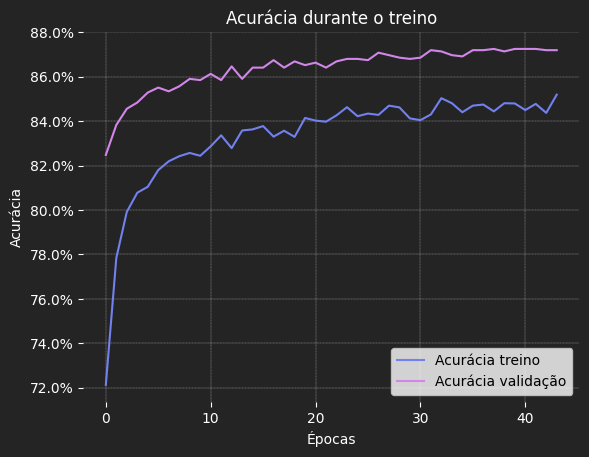

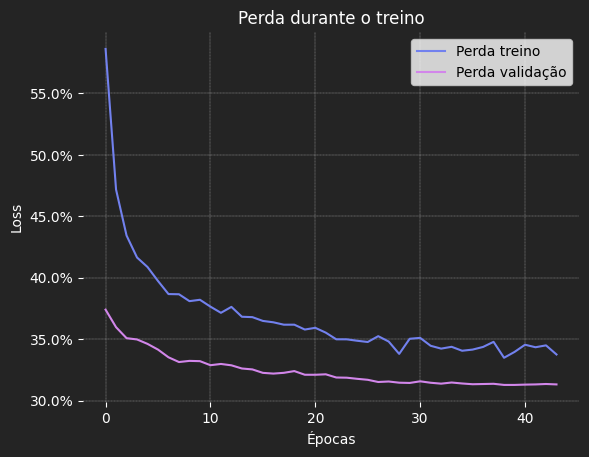

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Accuracy

fig, ax = plt.subplots()
# Lines and colors 
ax.plot(history.history['accuracy'], label='Acurácia treino', color='#7281EE')
ax.plot(history.history['val_accuracy'], label='Acurácia validação', color='#D286EA')
# Title and labels
ax.set_title('Acurácia durante o treino', color='white')
ax.set_xlabel('Épocas', color='white')
ax.set_ylabel('Acurácia', color='white')
ax.tick_params(colors='white')
# Legend
ax.legend()
# Grid
ax.grid(True, color='white', linestyle='--', linewidth=0.2)
# Background
ax.set_facecolor('#242424')
fig.patch.set_facecolor('#242424')
# Border
for spine in ax.spines.values():
    spine.set_visible(False)
# 'y' format
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.show()

# Accuracy

fig, ax = plt.subplots()
# Lines and colors 
ax.plot(history.history['loss'], label='Perda treino', color='#7281EE')
ax.plot(history.history['val_loss'], label='Perda validação', color='#D286EA')
# Title and labels
ax.set_title('Perda durante o treino', color='white')
ax.set_xlabel('Épocas', color='white')
ax.set_ylabel('Loss', color='white')
ax.tick_params(colors='white')
# Legend
ax.legend()
# Grid
ax.grid(True, color='white', linestyle='--', linewidth=0.2)
# Background
ax.set_facecolor('#242424')
fig.patch.set_facecolor('#242424')
# Border
for spine in ax.spines.values():
    spine.set_visible(False)
# 'y' format
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.show()
